In this task, you are provided with a set of train images that consist of icons
of objects. The set of icons in the training image are provided as shown in
figure 2. In this task you will implement algorithms for matching images,
similar to the principle of playing Dobble.

Output: Detect objects in the Test images, recognize to which class (from
the 50 Training image classes) they belong, and identify their bounding boxes.
One example of a test image is provided in figure 3. For visually demonstrating this, the function should open a box around each detected object and
indicate its class label. Demonstrate example images(s) of the outcome detection in your report.

Evaluate your algorithm on all Test images and report the overall False
Positive (FPR), True Positive (TPR) and accuracy (ACC) rates, and the
4
average runtime. Show and explain cases where this scheme finds difficulty to
perform correctly. Give insight about the complexity (memory and runtime)
of your algorithm in terms of the problem size e.g. how does the complexity
scale in terms of the number of image pixels, pyramid scales?

Creating scaled templates: You should create a Gaussian pyramid of
appropriate scale levels for each RGB Training image. This task includes
implementing appropriate Gaussian blurs and subsampling of the training
images through a hierarchy. You may use your own convolution algorithm
to apply the Gaussian blur, or you may use the library function. In your
report please explain the steps you take to build your Gaussian pyramids
and visually demonstrate an example pyramid for a Training image.

After creating scaled templates, you should append this set by creating
Gaussian pyramids for an appropriate number of orientations per class. This
creates the overall scaled and rotated templates. Justify your choice of parameters (e.g. Gaussian kernel specs, initial/final scales, number of scale
levels e.g. how many octaves, number of rotations etc). To justify quantitatively the chosen number of scales, plot or tabulate the overall object detection performance against these parameters and pick parameters that achieve
a reasonably good runtime vs. accuracy trade off. Evaluate your algorithm
on all Test images to report the overall Intersection over Union (IoU), False
Positive (FPR), True Positive (TPR) and Accuracy (ACC) rates, as well as
the average runtime. Refer to the following report http://host.robots.
ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf section 4.4 for further information about the evaluation metrics.

Pre-processing: For each (scaled) template set the background to zero,
similarly for the Test data. Intensity-based matching (related to output 2):
Slide each (scaled and rotated) template over the Test image to measure
their similarities across x-y axes. An intensity-based similarity score based
matching function. Explain why this function is suitable to measure image
similarities? Define appropriate thresholds on this similarity score, a proper
non-maxima suppression strategy to avoid false positives within the neighbourhood of the detected objects and return the output in terms of class
label and bounding box: [left top right bottom] for each object.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
from copy import copy
import task2

        classname  top  left  bottom  right
0  37-post-office  175   100     431    356
1       06-church  104    32     168     96
2       45-museum   55   241     119    305
3       35-police  413    27     477     91
4     50-cemetery   12   331     140    459


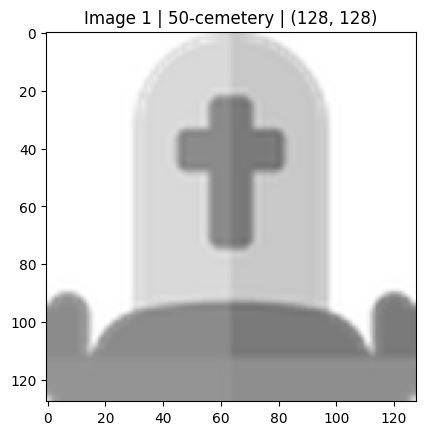

In [2]:
images = task2.images_with_annotations(Path("Task2Dataset"))

# Comment this out to operate on the entire dataset
images = [next(images)]

for (i, (img, annotations)) in enumerate(images):
    print(annotations)
    for row in annotations.itertuples():
        top, bot, left, right = row.left, row.right, row.top, row.bottom
        template = img[top:bot, left:right]
        plt.imshow(cv2.cvtColor(template, cv2.COLOR_GRAY2RGB))
        plt.title(f"Image {i + 1} | {row.classname} | {template.shape}")#, plt.show()

Bounding boxes with opencv

template 1 | errors [top, bot, left, right] = [0 0 0 0]
template 2 | errors [top, bot, left, right] = [0 0 0 0]
template 3 | errors [top, bot, left, right] = [0 0 0 0]
template 4 | errors [top, bot, left, right] = [0 0 0 0]
template 5 | errors [top, bot, left, right] = [0 0 0 0]


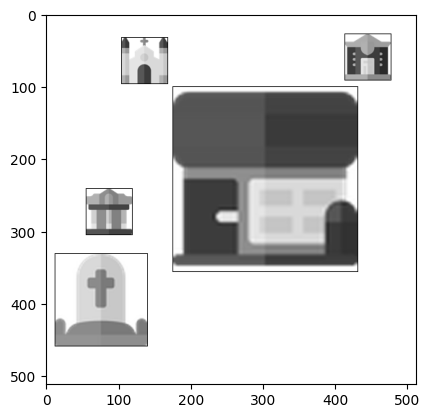

template 1 | errors [top, bot, left, right] = [ 63 127  45  19]
template 2 | errors [top, bot, left, right] = [ 39 103   6  70]
template 3 | errors [top, bot, left, right] = [164 228  35  99]
template 4 | errors [top, bot, left, right] = [ 12  12 167 167]


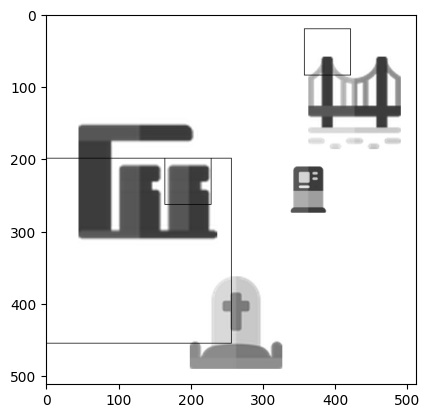

(<matplotlib.image.AxesImage at 0x7028be87f350>, None)

In [3]:
images = task2.images_with_annotations(Path("Task2Dataset"))

# Match templates for image 1 and display their bounding boxes
img, annotations = next(images)
template_bounds = [np.array([row.left, row.right, row.top, row.bottom])
              for row in annotations.itertuples()]
templates = [img[row.left:row.right, row.top:row.bottom] 
             for row in annotations.itertuples()]
task2.predict_bounding_boxes_cv2(img, templates, template_bounds)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)), plt.show()

# Attempt to match the same templates onto the next image
# This obviously fails
next_img, next_annotations = next(images)
next_template_bounds = [np.array([row.left, row.right, row.top, row.bottom])
              for row in next_annotations.itertuples()]
task2.predict_bounding_boxes_cv2(next_img, templates, next_template_bounds)
plt.imshow(cv2.cvtColor(next_img, cv2.COLOR_GRAY2RGB)), plt.show()
    

Example of Laplacian pyramid estimated with difference of Gaussian (DoG)


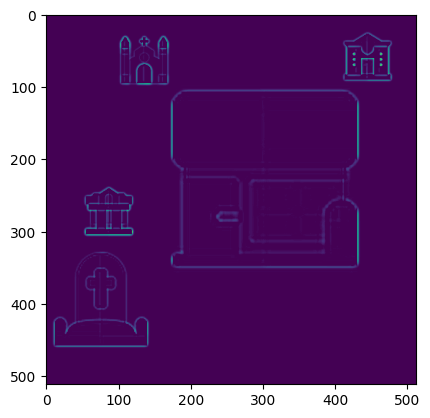

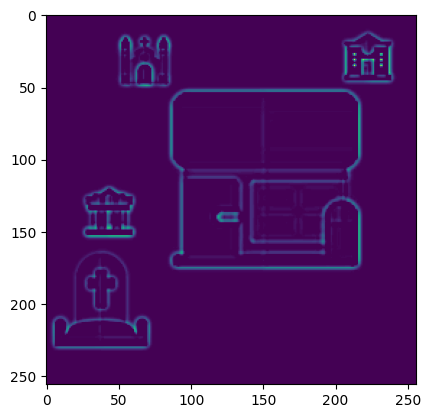

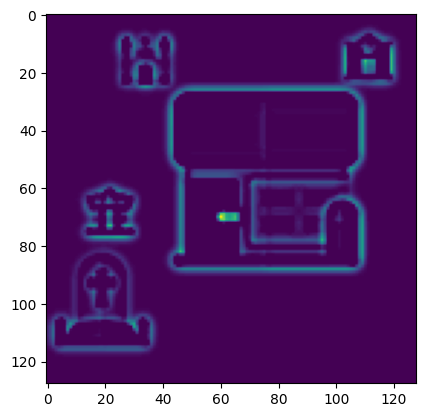

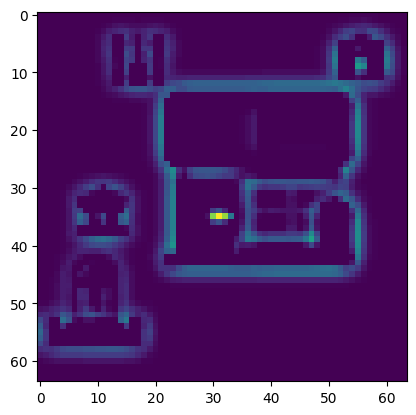

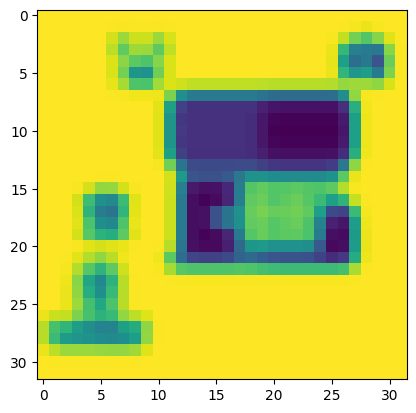

Reconstructed image from difference of gaussian


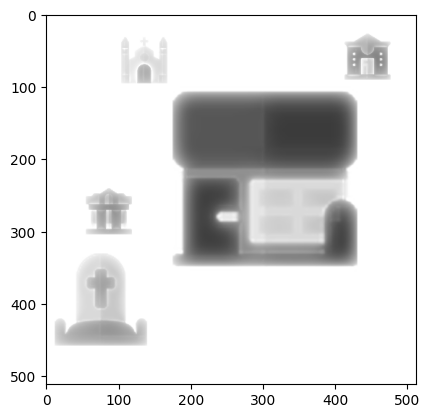

Original image for reference


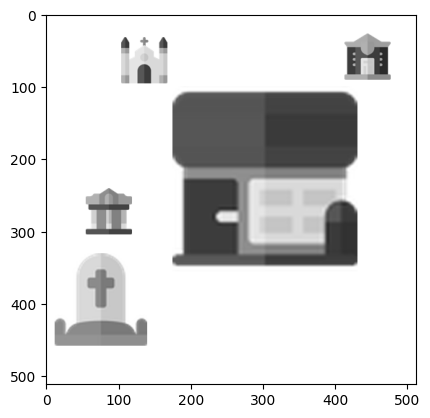

(<matplotlib.image.AxesImage at 0x7028bc2f2550>, None)

In [4]:
import copy

images = task2.images_with_annotations(Path("Task2Dataset"))
img, _ = next(images)

# print("Example of Gaussian pyramid")
# gauss_pyramid = task2.gaussian_pyrarmid(copy.deepcopy(img), 5)
# for level in gauss_pyramid:
#     plt.imshow(cv2.cvtColor(level, cv2.COLOR_GRAY2RGB)), plt.show()

print("Example of Laplacian pyramid estimated with difference of Gaussian (DoG)")
laplacian_pyr = task2.laplacian_pyramid(copy.deepcopy(img), 5)
for level in laplacian_pyr:
    plt.imshow(level), plt.show()

print("Reconstructed image from difference of gaussian")
reconstructed_image = laplacian_pyr.pop()
for layer in reversed(laplacian_pyr):
    reconstructed_image = cv2.pyrUp(reconstructed_image)
    reconstructed_image = cv2.add(reconstructed_image, layer)

plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_GRAY2RGB)), plt.show()

print("Original image for reference")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)), plt.show()

In [5]:
num_pyramid_levels = 5
def laplace(img, left, right, top, bot):
    template = img[left:right, top:bot]
    return task2.laplacian_pyramid(template, num_pyramid_levels)

(512, 512)


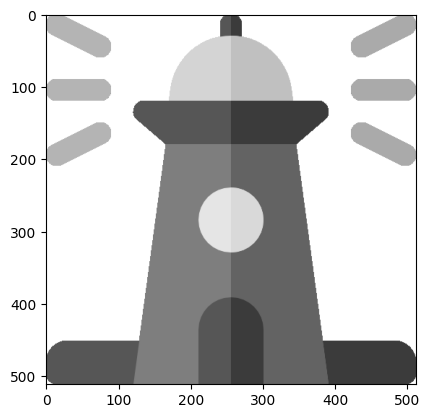

(256, 256)


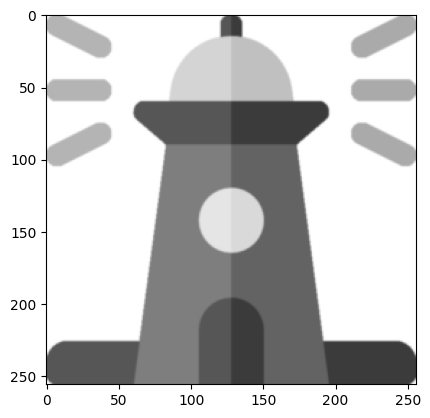

(128, 128)


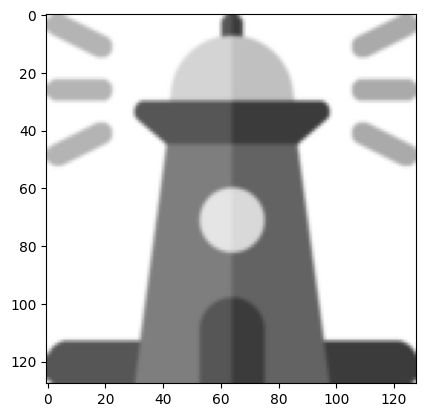

(64, 64)


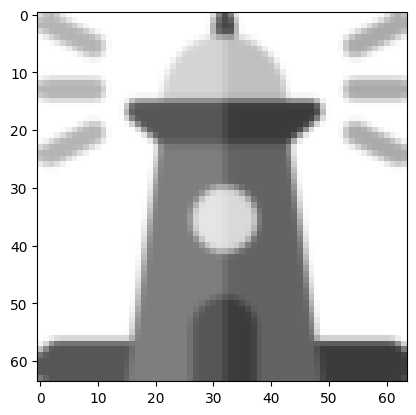

(32, 32)


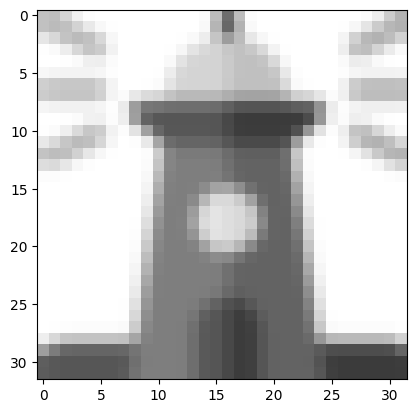

In [6]:
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"), num_pyramid_levels)
classname, template_pyr = next(templates)

for template in template_pyr:
    print(template.shape)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_GRAY2RGB)), plt.show()


Match found for 06-church at level: 0 with score: 0.9660936594009399 > 0.8, preds = [ 32  96 104 168]
Match found for 20-atm at level: 0 with score: 0.8089722990989685 > 0.8, preds = [266 330 377 441]
Match found for 31-field at level: 0 with score: 0.8669725656509399 > 0.8, preds = [ 33 225 191 383]
Match found for 35-police at level: 0 with score: 0.9669334888458252 > 0.8, preds = [ 27  91 413 477]
Match found for 37-post-office at level: 0 with score: 0.9350709915161133 > 0.8, preds = [100 356 175 431]
Match found for 45-museum at level: 0 with score: 0.9804367423057556 > 0.8, preds = [241 305  55 119]
Match found for 50-cemetery at level: 0 with score: 0.9952455163002014 > 0.8, preds = [331 459  12 140]


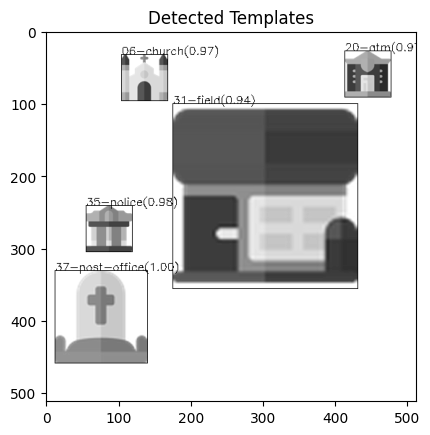

Match found for 03-bridge-1 at level: 0 with score: 0.9592142105102539 > 0.8, preds = [ 59 187 363 491]
Match found for 20-atm at level: 0 with score: 0.9725390076637268 > 0.8, preds = [211 275 331 395]
Match found for 27-gas-station at level: 0 with score: 0.9751336574554443 > 0.8, preds = [136 328  45 237]
Match found for 50-cemetery at level: 0 with score: 0.9952424764633179 > 0.8, preds = [363 491 199 327]


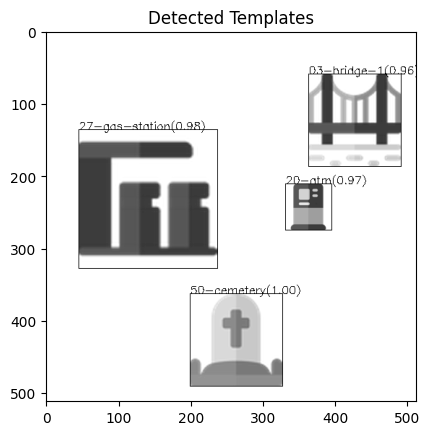

Match found for 05-silo at level: 0 with score: 0.9773673415184021 > 0.8, preds = [182 374 159 351]
Match found for 10-bench at level: 0 with score: 0.9652818441390991 > 0.8, preds = [317 381   4  68]
Match found for 19-prison at level: 0 with score: 0.9993807077407837 > 0.8, preds = [407 471 364 428]
Match found for 20-atm at level: 0 with score: 0.8375568985939026 > 0.8, preds = [293 357 268 332]
Match found for 31-field at level: 0 with score: 0.946738064289093 > 0.8, preds = [ 78 142  67 131]
Match found for 50-cemetery at level: 0 with score: 0.9976293444633484 > 0.8, preds = [406 470  31  95]


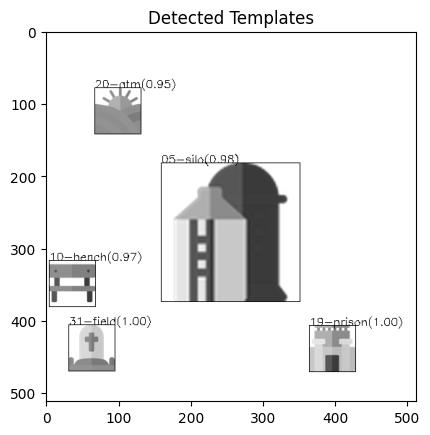

Match found for 01-lighthouse at level: 0 with score: 0.9782108664512634 > 0.8, preds = [351 479 362 490]
Match found for 03-bridge-1 at level: 0 with score: 0.959214985370636 > 0.8, preds = [366 494  60 188]
Match found for 08-courthouse at level: 0 with score: 0.9793143272399902 > 0.8, preds = [ 19 339 164 484]
Match found for 21-solar-panel at level: 0 with score: 0.9288089871406555 > 0.8, preds = [242 306  17  81]
Match found for 31-field at level: 0 with score: 0.8225159645080566 > 0.8, preds = [ 24  88 213 277]


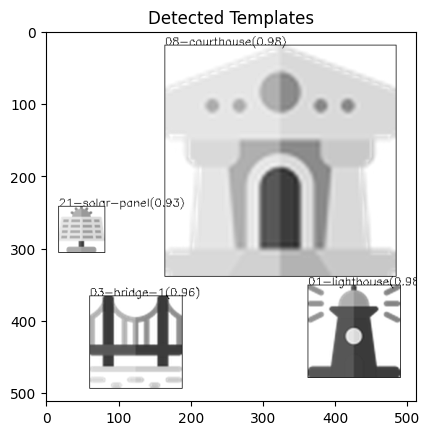

Match found for 08-courthouse at level: 0 with score: 0.9864383935928345 > 0.8, preds = [ 14 206  53 245]
Match found for 09-airport at level: 0 with score: 0.9653761386871338 > 0.8, preds = [190 254 248 312]
Match found for 10-bench at level: 0 with score: 0.9546613693237305 > 0.8, preds = [314 506 198 390]
Match found for 23-traffic-light at level: 0 with score: 0.8539965152740479 > 0.8, preds = [394 458  69 133]
Match found for 30-telephone-booth at level: 0 with score: 0.8541427254676819 > 0.8, preds = [118 182 117 181]
Match found for 31-field at level: 0 with score: 0.8967438340187073 > 0.8, preds = [307 371 244 308]
Match found for 33-hydrant at level: 0 with score: 0.9966052174568176 > 0.8, preds = [383 447  69 133]


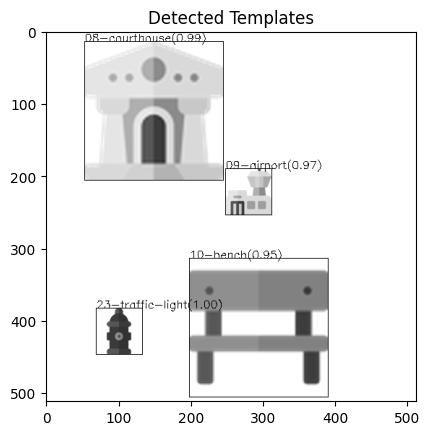

Match found for 10-bench at level: 0 with score: 0.9546632766723633 > 0.8, preds = [ 42 234  28 220]
Match found for 11-trash at level: 0 with score: 0.9962652325630188 > 0.8, preds = [263 327  92 156]
Match found for 20-atm at level: 0 with score: 0.9695969820022583 > 0.8, preds = [358 486  56 184]
Match found for 25-factory at level: 0 with score: 0.9727275967597961 > 0.8, preds = [290 418 253 381]
Match found for 31-field at level: 0 with score: 0.8967452049255371 > 0.8, preds = [ 35  99  74 138]


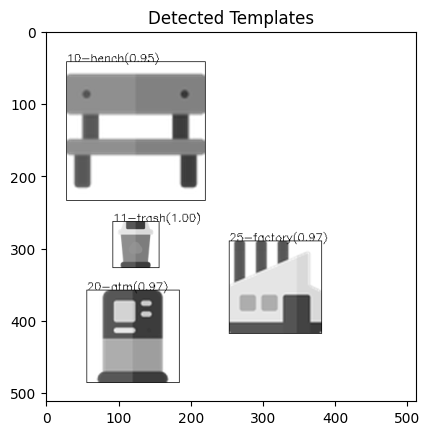

Match found for 06-church at level: 0 with score: 0.9642751216888428 > 0.8, preds = [  1 129  28 156]
Match found for 07-supermarket at level: 0 with score: 0.8915237784385681 > 0.8, preds = [182 246 142 206]
Match found for 37-post-office at level: 0 with score: 0.9526844620704651 > 0.8, preds = [417 481 187 251]
Match found for 38-library at level: 0 with score: 0.9656020402908325 > 0.8, preds = [ 58 186 289 417]
Match found for 41-windmill at level: 0 with score: 0.9829350113868713 > 0.8, preds = [254 446 259 451]


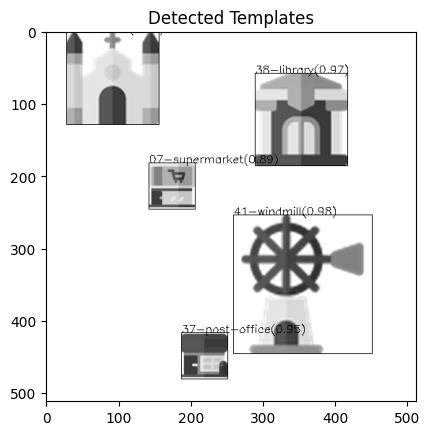

Match found for 01-lighthouse at level: 0 with score: 0.9782095551490784 > 0.8, preds = [  4 132 257 385]
Match found for 05-silo at level: 0 with score: 0.9773673415184021 > 0.8, preds = [109 301  12 204]
Match found for 09-airport at level: 0 with score: 0.9653777480125427 > 0.8, preds = [392 456 228 292]
Match found for 11-trash at level: 0 with score: 0.8065680861473083 > 0.8, preds = [241 305 293 357]
Match found for 20-atm at level: 0 with score: 0.8375576138496399 > 0.8, preds = [220 284 121 185]
Match found for 31-field at level: 0 with score: 0.8274654746055603 > 0.8, preds = [ 89 153  90 154]
Match found for 45-museum at level: 0 with score: 0.9741765856742859 > 0.8, preds = [149 341 260 452]
Match found for 50-cemetery at level: 0 with score: 0.8230254054069519 > 0.8, preds = [170 234 293 357]


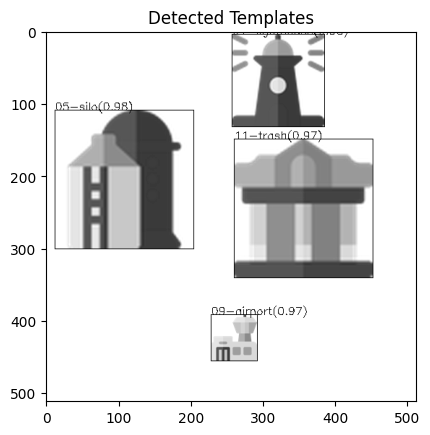

Match found for 07-supermarket at level: 0 with score: 0.8915220499038696 > 0.8, preds = [148 212  93 157]
Match found for 20-atm at level: 0 with score: 0.8136378526687622 > 0.8, preds = [250 314 166 230]
Match found for 27-gas-station at level: 0 with score: 0.9751336574554443 > 0.8, preds = [208 400 176 368]
Match found for 31-field at level: 0 with score: 0.9467372894287109 > 0.8, preds = [408 472  52 116]
Match found for 34-billboard at level: 0 with score: 0.9587726593017578 > 0.8, preds = [195 259 410 474]


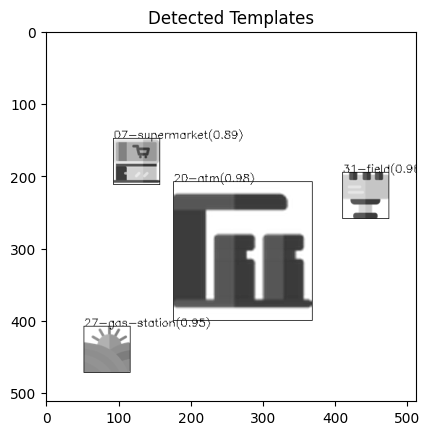

Match found for 08-courthouse at level: 0 with score: 0.9944588541984558 > 0.8, preds = [342 406 293 357]
Match found for 12-bus at level: 0 with score: 0.9669814705848694 > 0.8, preds = [ 16 208  68 260]
Match found for 26-shop at level: 0 with score: 0.9634504318237305 > 0.8, preds = [ 46 174 306 434]
Match found for 29-theater at level: 0 with score: 0.965771496295929 > 0.8, preds = [257 321 245 309]
Match found for 31-field at level: 0 with score: 0.8095898628234863 > 0.8, preds = [  3 131 104 232]


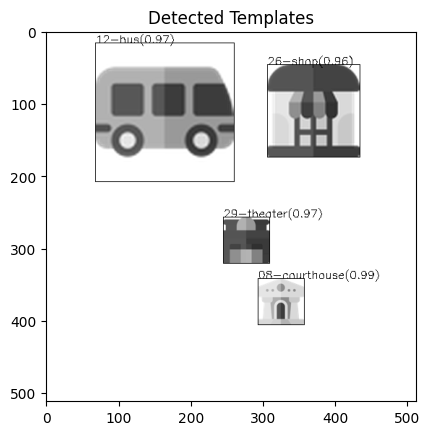

Match found for 06-church at level: 0 with score: 0.9660924673080444 > 0.8, preds = [ 91 155 318 382]
Match found for 11-trash at level: 0 with score: 0.8001874685287476 > 0.8, preds = [100 164  74 138]
Match found for 23-traffic-light at level: 0 with score: 0.8184728622436523 > 0.8, preds = [106 170 137 201]
Match found for 24-fountain at level: 0 with score: 0.990463137626648 > 0.8, preds = [294 358 147 211]
Match found for 30-telephone-booth at level: 0 with score: 0.8534478545188904 > 0.8, preds = [102 166  74 138]
Match found for 31-field at level: 0 with score: 0.8918474316596985 > 0.8, preds = [ 15  79 111 175]
Match found for 33-hydrant at level: 0 with score: 0.8356301784515381 > 0.8, preds = [ 88 152 138 202]
Match found for 42-tractor at level: 0 with score: 0.9833251237869263 > 0.8, preds = [163 227 313 377]
Match found for 43-sign at level: 0 with score: 0.9800539016723633 > 0.8, preds = [280 472 259 451]
Match found for 47-restaurant at level: 0 with score: 0.95155900716

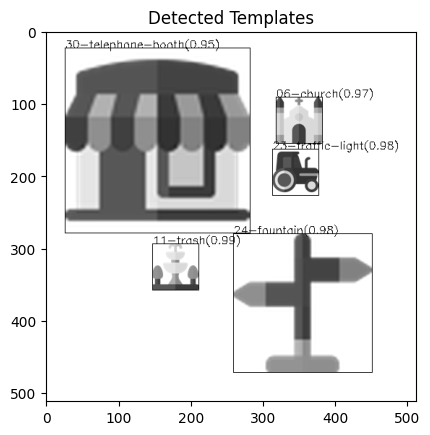

Match found for 04-bridge at level: 0 with score: 0.987278401851654 > 0.8, preds = [210 402 105 297]
Match found for 07-supermarket at level: 0 with score: 0.8826427459716797 > 0.8, preds = [ 18 146 142 270]
Match found for 28-government at level: 0 with score: 0.9886175394058228 > 0.8, preds = [107 171 336 400]
Match found for 31-field at level: 0 with score: 0.8358389139175415 > 0.8, preds = [  5  69 155 219]
Match found for 32-van at level: 0 with score: 0.9490720629692078 > 0.8, preds = [291 419 369 497]


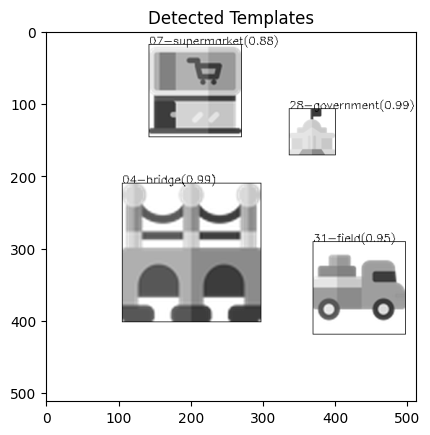

Match found for 24-fountain at level: 0 with score: 0.9865642786026001 > 0.8, preds = [270 398 361 489]
Match found for 27-gas-station at level: 0 with score: 0.9782490134239197 > 0.8, preds = [133 261 101 229]
Match found for 31-field at level: 0 with score: 0.8036914467811584 > 0.8, preds = [352 416 116 180]
Match found for 36-hotel at level: 0 with score: 0.9508284330368042 > 0.8, preds = [27 91 16 80]
Match found for 42-tractor at level: 0 with score: 0.983326256275177 > 0.8, preds = [  7  71 392 456]
Match found for 43-sign at level: 0 with score: 0.9800522327423096 > 0.8, preds = [314 506  96 288]
Match found for 50-cemetery at level: 0 with score: 0.8289519548416138 > 0.8, preds = [334 398 394 458]


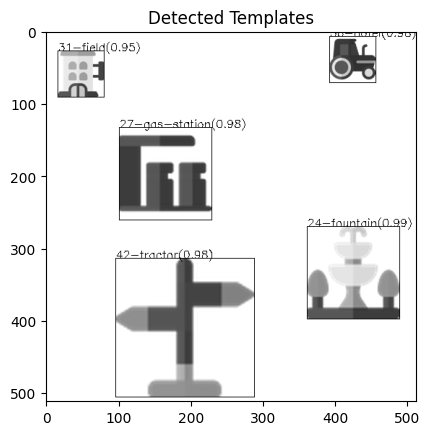

Match found for 03-bridge-1 at level: 0 with score: 0.9592127799987793 > 0.8, preds = [ 10 138  62 190]
Match found for 06-church at level: 0 with score: 0.964277446269989 > 0.8, preds = [375 503 382 510]
Match found for 11-trash at level: 0 with score: 0.8184655904769897 > 0.8, preds = [221 285 165 229]
Match found for 43-sign at level: 0 with score: 0.9830651879310608 > 0.8, preds = [186 314 320 448]
Match found for 49-school at level: 0 with score: 0.9511248469352722 > 0.8, preds = [157 285 133 261]


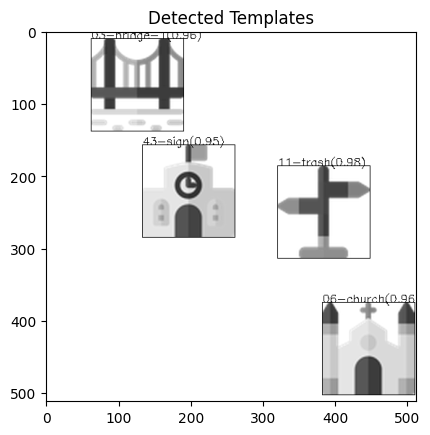

Match found for 07-supermarket at level: 0 with score: 0.882641613483429 > 0.8, preds = [ 17 145 208 336]
Match found for 25-factory at level: 0 with score: 0.9727293848991394 > 0.8, preds = [265 393 370 498]
Match found for 31-field at level: 0 with score: 0.8358416557312012 > 0.8, preds = [  4  68 221 285]
Match found for 43-sign at level: 0 with score: 0.9830651879310608 > 0.8, preds = [347 475 183 311]
Match found for 44-ferris-wheel at level: 0 with score: 0.9746627807617188 > 0.8, preds = [431 495  97 161]
Match found for 47-restaurant at level: 0 with score: 0.9634117484092712 > 0.8, preds = [347 411 100 164]


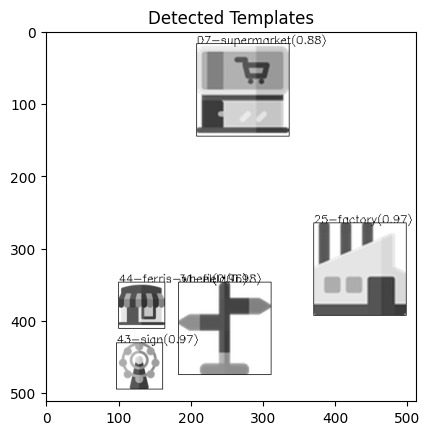

Match found for 06-church at level: 0 with score: 0.9621280431747437 > 0.8, preds = [186 378  74 266]
Match found for 28-government at level: 0 with score: 0.982250452041626 > 0.8, preds = [ 27 219 282 474]
Match found for 30-telephone-booth at level: 0 with score: 0.8065270185470581 > 0.8, preds = [256 320  59 123]
Match found for 33-hydrant at level: 0 with score: 0.8651115298271179 > 0.8, preds = [185 249  59 123]
Match found for 37-post-office at level: 0 with score: 0.9526858329772949 > 0.8, preds = [ 28  92 186 250]
Match found for 42-tractor at level: 0 with score: 0.9833265542984009 > 0.8, preds = [ 70 134  76 140]


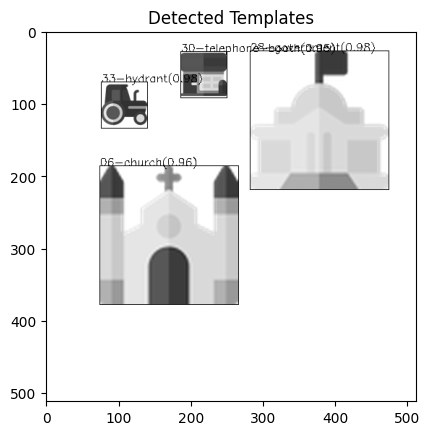

Match found for 15-barn at level: 0 with score: 0.9729074835777283 > 0.8, preds = [153 217 379 443]
Match found for 21-solar-panel at level: 0 with score: 0.9288089871406555 > 0.8, preds = [353 417  54 118]
Match found for 23-traffic-light at level: 0 with score: 0.8539981245994568 > 0.8, preds = [100 164 223 287]
Match found for 33-hydrant at level: 0 with score: 0.9966046214103699 > 0.8, preds = [ 89 153 223 287]
Match found for 34-billboard at level: 0 with score: 0.9501509070396423 > 0.8, preds = [248 504 158 414]


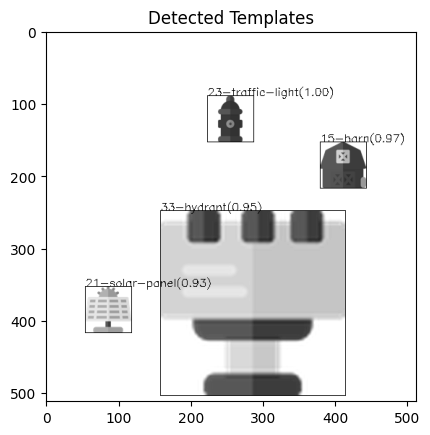

Match found for 20-atm at level: 0 with score: 0.9695969820022583 > 0.8, preds = [141 269  58 186]
Match found for 28-government at level: 0 with score: 0.9841430187225342 > 0.8, preds = [148 276 288 416]
Match found for 35-police at level: 0 with score: 0.9669334888458252 > 0.8, preds = [403 467 145 209]
Match found for 36-hotel at level: 0 with score: 0.9458315372467041 > 0.8, preds = [322 450 341 469]


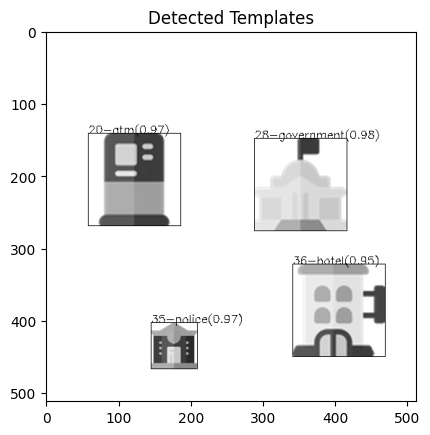

Match found for 06-church at level: 0 with score: 0.9621270298957825 > 0.8, preds = [256 448 260 452]
Match found for 09-airport at level: 0 with score: 0.9653777480125427 > 0.8, preds = [152 216 447 511]
Match found for 12-bus at level: 0 with score: 0.9697542786598206 > 0.8, preds = [190 318  56 184]
Match found for 30-telephone-booth at level: 0 with score: 0.8065295815467834 > 0.8, preds = [326 390 245 309]
Match found for 31-field at level: 0 with score: 0.8290904760360718 > 0.8, preds = [195 259 109 173]
Match found for 33-hydrant at level: 0 with score: 0.865112841129303 > 0.8, preds = [255 319 245 309]
Match found for 44-ferris-wheel at level: 0 with score: 0.9689850807189941 > 0.8, preds = [  9 137  40 168]


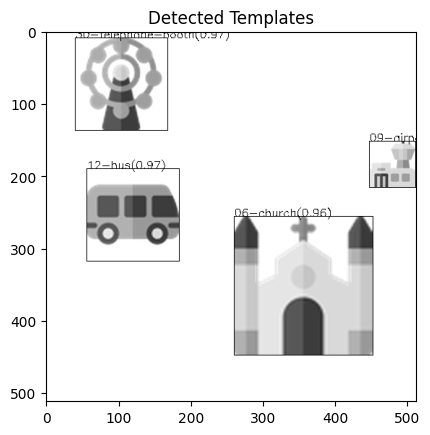

Match found for 03-bridge-1 at level: 0 with score: 0.9553249478340149 > 0.8, preds = [ 72 264  16 208]
Match found for 20-atm at level: 0 with score: 0.81363844871521 > 0.8, preds = [ 89 153 304 368]
Match found for 23-traffic-light at level: 0 with score: 0.9914851188659668 > 0.8, preds = [358 486 134 262]
Match found for 27-gas-station at level: 0 with score: 0.9751341342926025 > 0.8, preds = [ 47 239 314 506]
Match found for 33-hydrant at level: 0 with score: 0.8352717757225037 > 0.8, preds = [336 464 134 262]
Match found for 43-sign at level: 0 with score: 0.9861716628074646 > 0.8, preds = [246 310 231 295]
Match found for 46-fire-station at level: 0 with score: 0.9664947390556335 > 0.8, preds = [313 441 271 399]


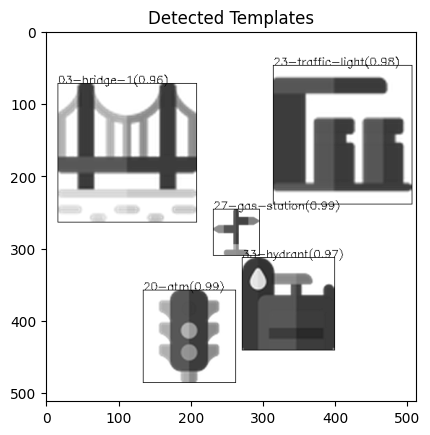

In [317]:
image_pyramid_levels = 5
images = task2.images_with_annotations(Path("Task2Dataset"))
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"))
templates = [(classname, pyr) for (classname, pyr) in templates]

for img, annotations in images:
    img_pyr = task2.gaussian_pyrarmid(img, image_pyramid_levels)
    classnames, scores, pred_boxes = task2.predict_all_templates(img_pyr, templates)
    task2.non_max_suppression(pred_boxes, scores)
    task2.annotate_predictions(img, classnames, scores, pred_boxes)

    plt.imshow(img, cmap='gray')
    plt.title('Detected Templates')
    plt.show()

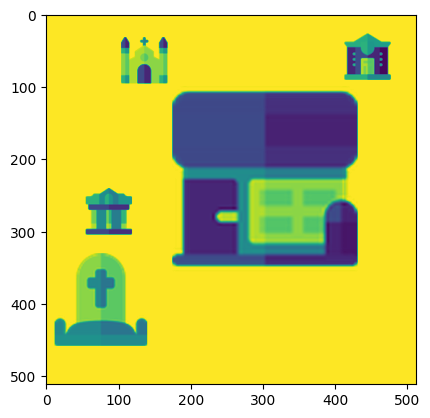

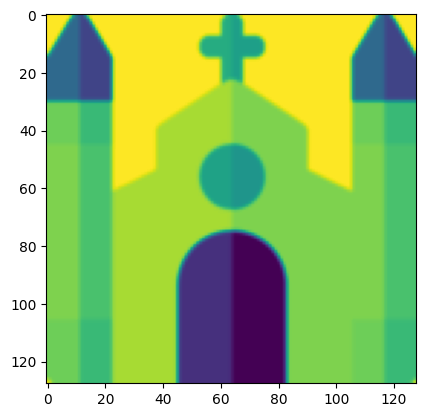

opencv matchtemplate


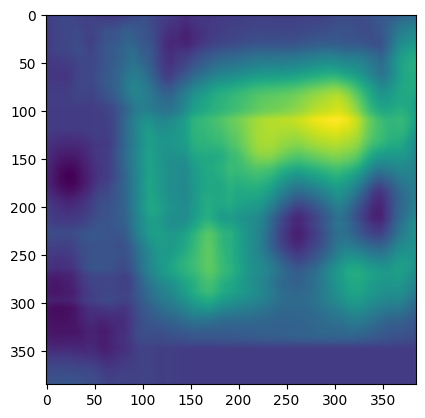

(55724160.0, 315788128.0, (24, 168), (303, 109))
fft ssd


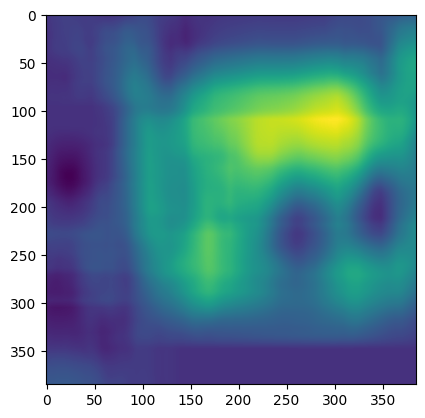

(11602.740753270902, 84063.3624567368, (24, 168), (299, 110))
new fft ssd


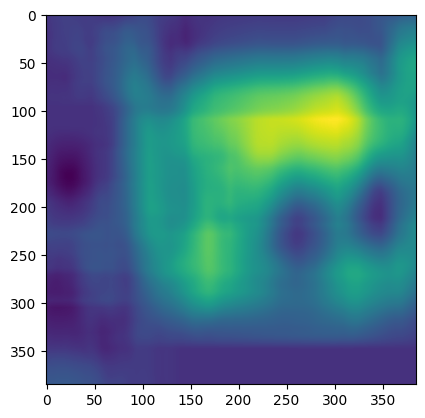

(11602.7407532709, 84063.3624567368, (24, 168), (299, 110))
23003681481271.73


In [314]:
num_pyramid_levels = 5
images = task2.images_with_annotations(Path("Task2Dataset"))
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"), num_pyramid_levels)

img, annotations = next(images)
# norm_image = (img - np.mean(img)) / np.std(img)
# plt.imshow(img), plt.show()    
# plt.imshow(norm_image), plt.show()    
    # norm_template = (template - np.mean(template)) / np.std(template)
# plt.imshow(img), plt.show()    
classname, pyr = next(templates)
while classname != "06-church":
    classname, pyr = next(templates)
template = pyr[2]
plt.imshow(img), plt.show()
plt.imshow(template), plt.show()

# print("template shape: ", template.shape)
# img_copy = img.copy()
# result_same_size_test = cv2.matchTemplate(img_copy, template, cv2.TM_SQDIFF) # <-- this is not allowed
# print(cv2.minMaxLoc(result_same_size_test))

# multi_scale_template_matching(img, template)

print("opencv matchtemplate")
result = cv2.matchTemplate(img, template, cv2.TM_SQDIFF) # <-- this is not allowed
plt.imshow(result), plt.show()
print(cv2.minMaxLoc(result))

print("fft ssd")
ssd_norm = task2.correlate_ssd_normed(img, template)
plt.imshow(ssd_norm), plt.show()
print(cv2.minMaxLoc(ssd_norm))

print("new fft ssd")
ssd_norm2 = task2.correlate_ssd_normed2(img, template)
plt.imshow(ssd_norm2), plt.show()
print(cv2.minMaxLoc(ssd_norm2))

print(np.sum(np.abs(result - ssd_norm)))

# annotated_img = img.copy()
# for (img, annotations) in images:
# task2.predict_all_templates(templates, img, annotations, annotated_img, num_pyramid_levels)
# plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_GRAY2RGB)), plt.show()    

256 256


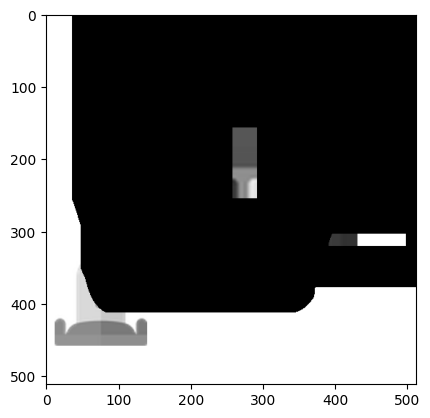

128 128


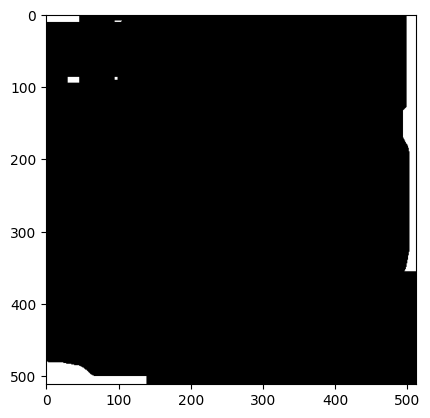

64 64


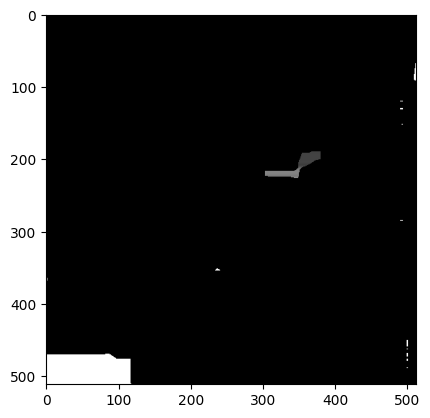

32 32


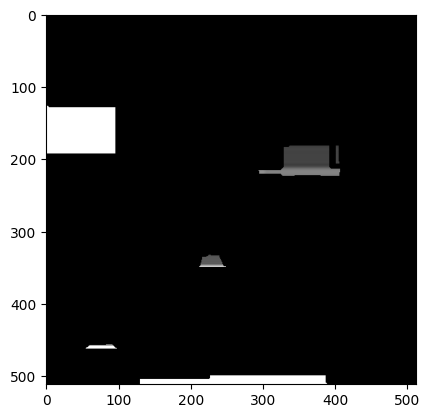

16 16


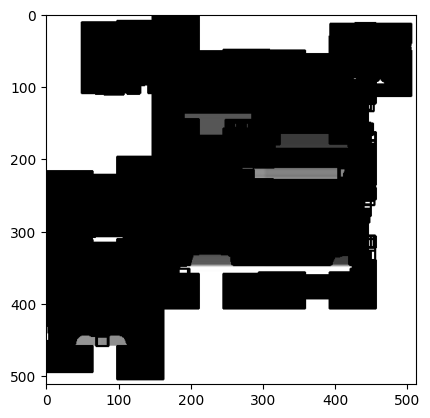

In [113]:
images = task2.images_with_annotations(Path("Task2Dataset"))
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"), num_pyramid_levels)

img, annotations = next(images)
classname, template = next(templates)
while classname != "06-church": classname, template = next(templates)
annotated_img = img.copy()

results = []
for i in range(5):
    template = cv2.pyrDown(template)
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # <-- this is probably not allowed
    loc = np.where(res >= 0.8)
    annotated_img = img.copy()
    for pt in zip(*loc[::-1]):
        cv2.rectangle(annotated_img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    print(w, h)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_GRAY2RGB)), plt.show()


# result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # <-- this is probably not allowed
# min_val, _, min_loc, max_loc = cv2.minMaxLoc(result)
# h, w = template.shape
# # for (x, y) in zip(cols, rows):
# black = (0, 255, 0)
# cv2.rectangle(annotated_img, (max_loc[0], max_loc[1]), (max_loc[0] + 64, max_loc[1] + 64), color=black,
#                 thickness=1)
# cv2.putText(annotated_img, classname, (max_loc[0], max_loc[1]), 
#             cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=black)
    
# plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_GRAY2RGB)), plt.show()    

37-post-office	| PASS | errors [top, bot, left, right] = [0 0 0 0] | total error = 0
06-church	| PASS | errors [top, bot, left, right] = [0 0 0 0] | total error = 0
45-museum	| PASS | errors [top, bot, left, right] = [0 0 0 0] | total error = 0
35-police	| PASS | errors [top, bot, left, right] = [0 0 0 0] | total error = 0
50-cemetery	| PASS | errors [top, bot, left, right] = [0 0 0 0] | total error = 0


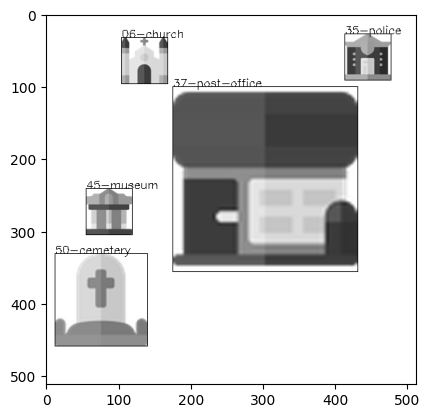

37-post-office	| PASS | Correctly didn't match template
06-church	| PASS | Correctly didn't match template
45-museum	| PASS | Correctly didn't match template
35-police	| PASS | Correctly didn't match template
50-cemetery	| PASS | errors [top, bot, left, right] = [0 0 0 0] | total error = 0


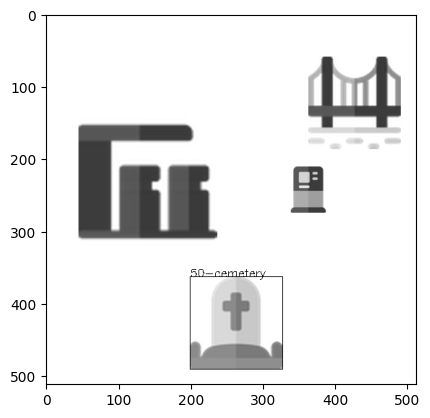

(<matplotlib.image.AxesImage at 0x79731d5c9c50>, None)

In [37]:
images = task2.images_with_annotations(Path("Task2Dataset"))

img, annotations = next(images)
templates = [(row.classname, 
              laplace(img, row.left, row.right, row.top, row.bottom))
             for row in annotations.itertuples()]  
task2.predict_all_templates(templates, img, annotations, img, num_pyramid_levels)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)), plt.show()    

# Do it again for the next image, but this time keep the same templates
next_img, next_annotations = next(images)
task2.predict_all_templates(templates, next_img, next_annotations, next_img, num_pyramid_levels)
plt.imshow(cv2.cvtColor(next_img, cv2.COLOR_GRAY2RGB)), plt.show()  
